In [1]:
import pprint as pp
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

engineer_mode = True # True = Don't show plots etc.

mode = "train" # Use train dataset

if mode == "train":
    samples = pd.read_csv("vu-dmt-assigment-2-2023/training_set_VU_DM.csv")
else:
    samples = pd.read_csv("vu-dmt-assigment-2-2023/test_set_VU_DM.csv")


In [2]:
samples.info()
samples.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 54 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  position                     int64  
 15  price_usd                    float64
 16  promotion_flag               int64  
 17  srch_destination_id          int64  
 18  srch_length_of_stay          int64  
 19  

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [3]:
# No duplicates rows exist in the training samples
samples[samples.duplicated()]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool


In [4]:
samples["date_time"] = pd.to_datetime(samples["date_time"])
samples['date_time'] = [datetime.timestamp(x) for x in samples["date_time"]]

Training samples and the test samples have almost the same amount of rows.

# Undersample our data

In [5]:
# Undersample_data
def undersample_data(df, column, alpha):
    X_train, y_train = df.drop(column, axis=1), df[column]
    smote = RandomUnderSampler(random_state=27, sampling_strategy=alpha)
    X, y = smote.fit_resample(X_train, y_train)
    print("Before undersampling: ", Counter(y_train))
    print("After undersampling: ", Counter(y))
    oversampled_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
    return oversampled_df

# Undersample multi data
def undersample_multi_data(df, column, alpha):
    X_train, y_train = df.drop(column, axis=1), df[column]
    a, b = Counter(undersampled[column]).most_common()[0]

    # Create a dictionary with the desired sample count for class 4
    sampling_strategy = {}
    sampling_strategy[a] = round(b/4)

    rus = RandomUnderSampler(random_state=27, sampling_strategy=sampling_strategy)
    X, y = rus.fit_resample(X_train, y_train)
    print("Before undersampling: ", Counter(y_train))
    print("After undersampling: ", Counter(y))

    oversampled_df = pd.concat([pd.DataFrame(X, columns=X_train.columns), pd.DataFrame(y, columns=[column])], axis=1)

    return oversampled_df

if mode == "train":
    undersampled = undersample_data(samples, "booking_bool", 0.7)

    to_under_sample = ["site_id",
                       "visitor_location_country_id",
                       "prop_country_id",
                       "srch_length_of_stay",
                       "srch_room_count"]

    end_df = undersampled

    alpha = 0.5
    for under in to_under_sample:
        end_df = undersample_multi_data(end_df, under, alpha)

Before undersampling:  Counter({0: 4819957, 1: 138390})
After undersampling:  Counter({0: 197700, 1: 138390})
Before undersampling:  Counter({5: 209791, 14: 32348, 15: 21270, 24: 16786, 32: 11579, 18: 8444, 16: 5874, 12: 4722, 22: 2692, 9: 2669, 19: 2589, 11: 2403, 7: 2380, 31: 2050, 29: 1972, 26: 1092, 4: 839, 25: 822, 1: 795, 23: 768, 34: 683, 10: 558, 13: 554, 27: 411, 17: 387, 2: 352, 28: 273, 30: 271, 3: 245, 21: 239, 6: 176, 33: 41, 20: 14, 8: 1})
After undersampling:  Counter({5: 52448, 14: 32348, 15: 21270, 24: 16786, 32: 11579, 18: 8444, 16: 5874, 12: 4722, 22: 2692, 9: 2669, 19: 2589, 11: 2403, 7: 2380, 31: 2050, 29: 1972, 26: 1092, 4: 839, 25: 822, 1: 795, 23: 768, 34: 683, 10: 558, 13: 554, 27: 411, 17: 387, 2: 352, 28: 273, 30: 271, 3: 245, 21: 239, 6: 176, 33: 41, 20: 14, 8: 1})
Before undersampling:  Counter({219: 52854, 100: 32821, 55: 19479, 216: 14971, 220: 11242, 129: 7878, 31: 5874, 99: 4255, 59: 3099, 92: 2663, 158: 2577, 103: 2431, 132: 2099, 39: 1189, 117: 1025, 

In [6]:
# Plot the counts
def plot_data(df, is_float):
    num_rows = len(df.columns) // 2 + len(df.columns) % 2

    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*3))

    for i, col in enumerate(df.columns):
        ax = axs.flatten()[i]
        if not is_float:
            sns.histplot(df[col], ax=ax)
        else:
            sns.scatterplot(x=df.index, y=df[col], ax=ax)
        ax.set_title(col)

    # Remove unused subplots
    if len(df.columns) % 2 != 0:
        fig.delaxes(axs.flatten()[-1])

    plt.tight_layout()
    plt.show()

In [7]:
# if mode == "train" and not engineer_mode:
#     float_cols = clean_training2.select_dtypes(include=["float64"])
#     int_cols = clean_training2.select_dtypes(include=["int64"])

#     plot_data(clean_training2[int_cols.columns], False)
#     plot_data(clean_training2[float_cols.columns], True)
    
# plot_data(end_df[int_cols.columns], False)

### Missing Data

<AxesSubplot:>

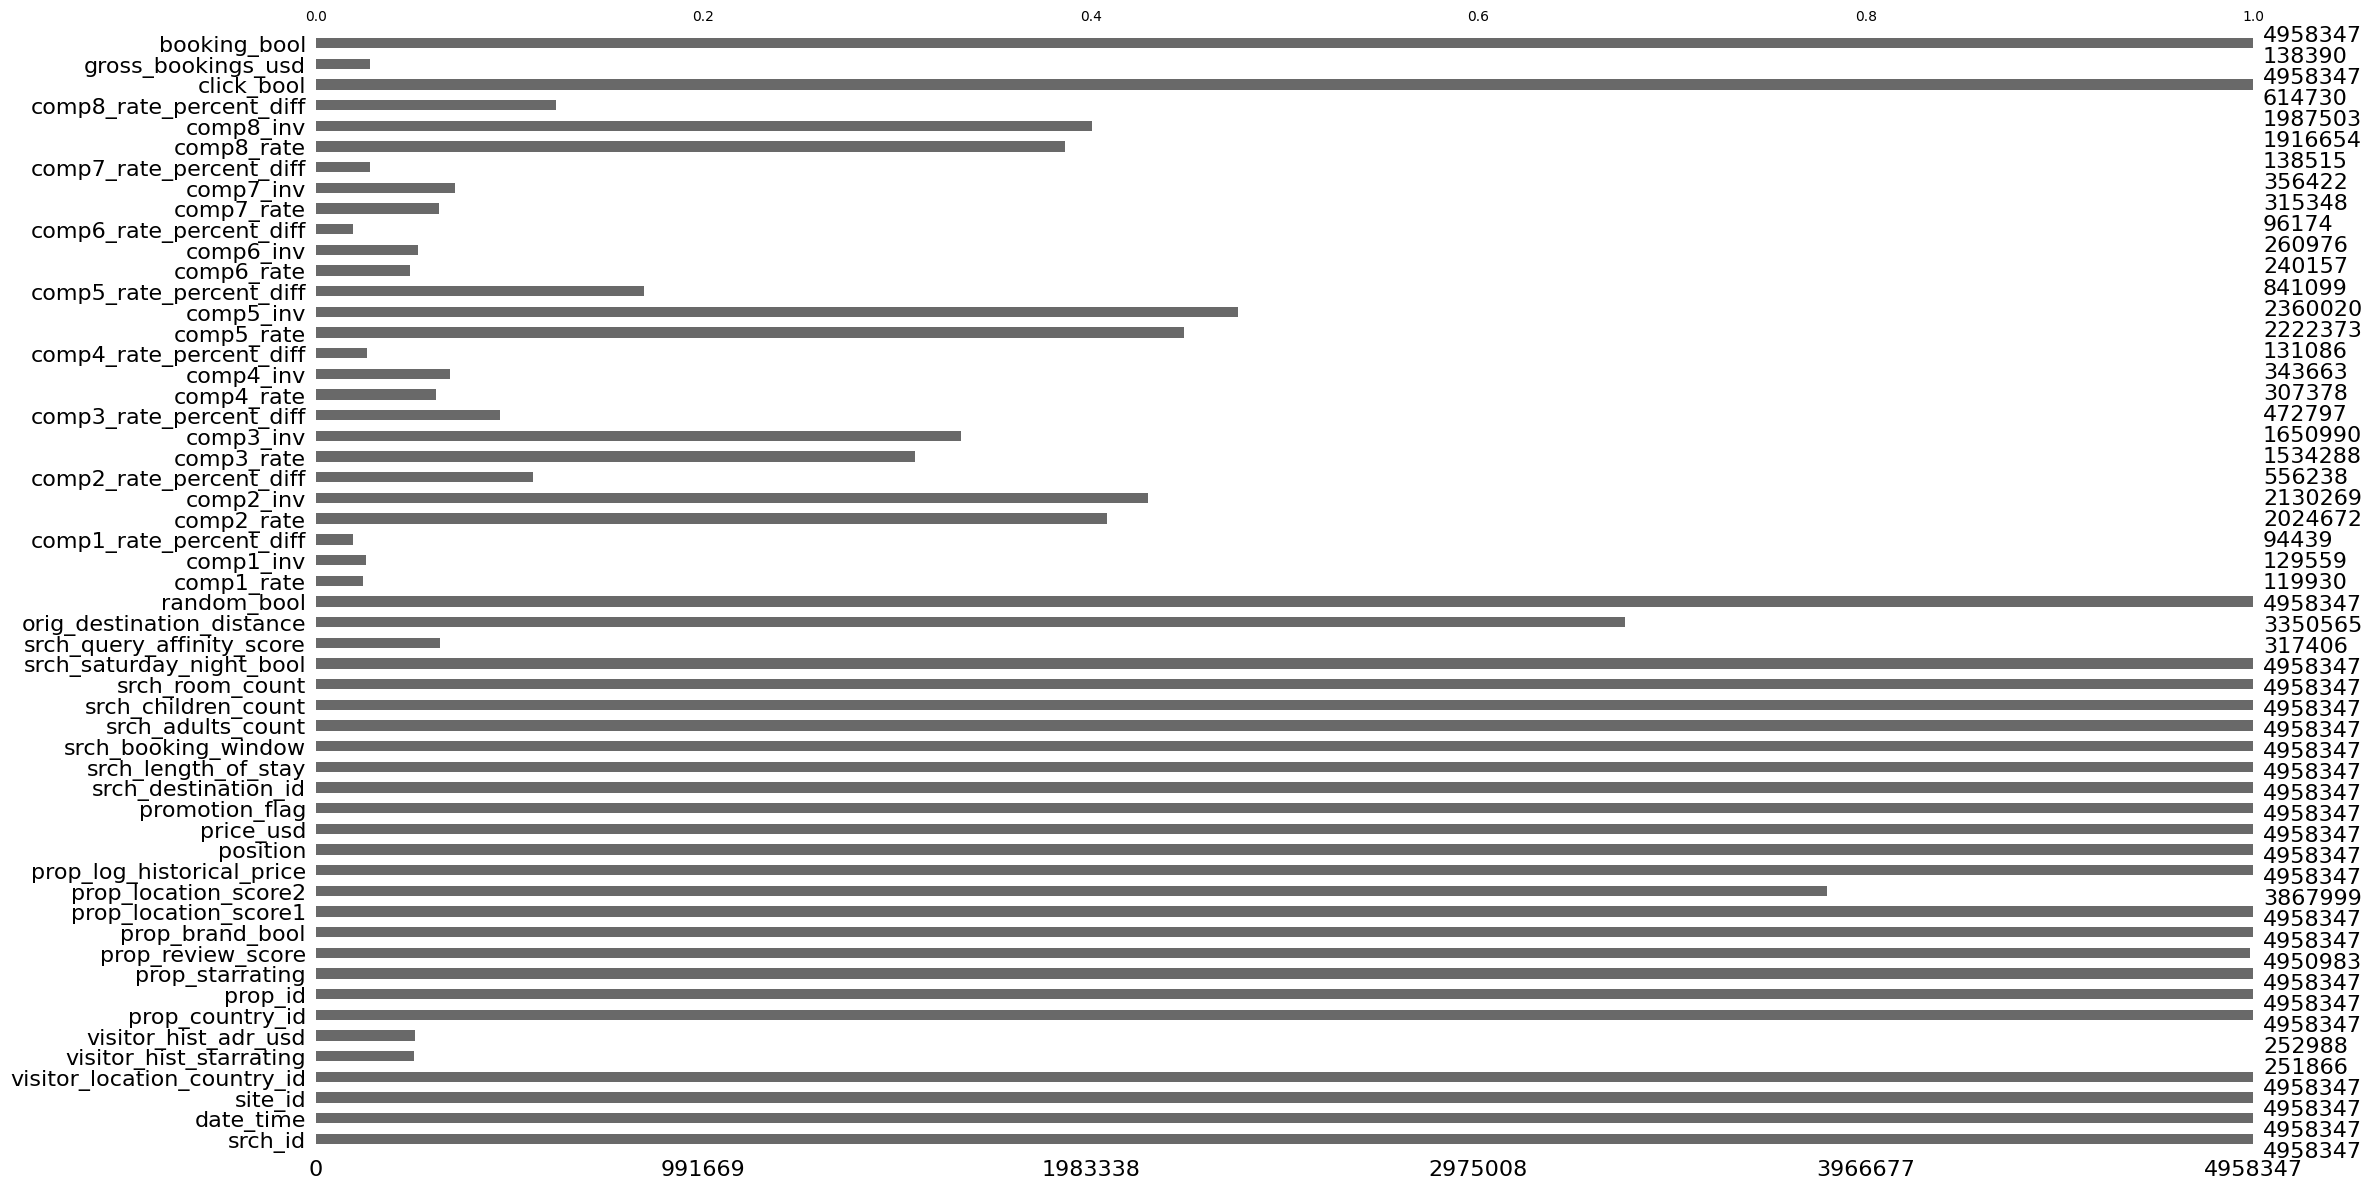

In [8]:
import missingno as msno

# Show how complete each variable it
msno.bar(samples)

In [9]:
def fill_columns(df):
    new_df = df
    new_df["date_time"] = [datetime.fromtimestamp(x) for x in new_df["date_time"]]

    # Some variables we can set to 0 rather than 0
    set_zero = ["prop_review_score", "srch_query_affinity_score", "prop_location_score2"]

    if mode == "train":
        set_zero.append("gross_bookings_usd")

    new_df[set_zero] = new_df[set_zero].fillna(0)

    # Fill missing competitor data with zeros
    cols = [c for c in new_df.columns if "comp" in c]
    new_df[cols] = new_df[cols].fillna(0)

    to_fill = ["orig_destination_distance", "visitor_hist_adr_usd", "visitor_hist_starrating"]

    # Fill where orig_destination_distance is missing with the mean of the same prop_id and visitor_location_country_id
    print("Filling orig_destination_distance...")
    new_df["orig_destination_distance"] = new_df.groupby(["prop_id", "visitor_location_country_id"])["orig_destination_distance"].transform(lambda x: x.fillna(x.mean()))

    # Fill the remaining missing orig_destination_distance with the mean of the same prop_id
    new_df["orig_destination_distance"] = new_df.groupby(["prop_id"])["orig_destination_distance"].transform(lambda x: x.fillna(x.mean()))
    

    # Fill the remaining visitor_hist_adr_usd missing for a date_time, it will be filled with the last occurred value prior to that date_time
    print("Filling visitor_hist_adr_usd...")
    new_df["visitor_hist_adr_usd"] = new_df.groupby(["srch_id", "date_time"])["visitor_hist_adr_usd"].transform(lambda x: x.fillna(method="ffill"))

    # new_df["visitor_hist_adr_usd"] = new_df.groupby(["prop_id"])["visitor_hist_adr_usd"].transform(lambda x: x.fillna(method="ffill"))
    new_df = new_df.drop(to_fill, axis=1)

    return new_df

In [10]:
cleaner_samples = fill_columns(end_df)

Filling orig_destination_distance...
Filling visitor_hist_adr_usd...


<AxesSubplot:>

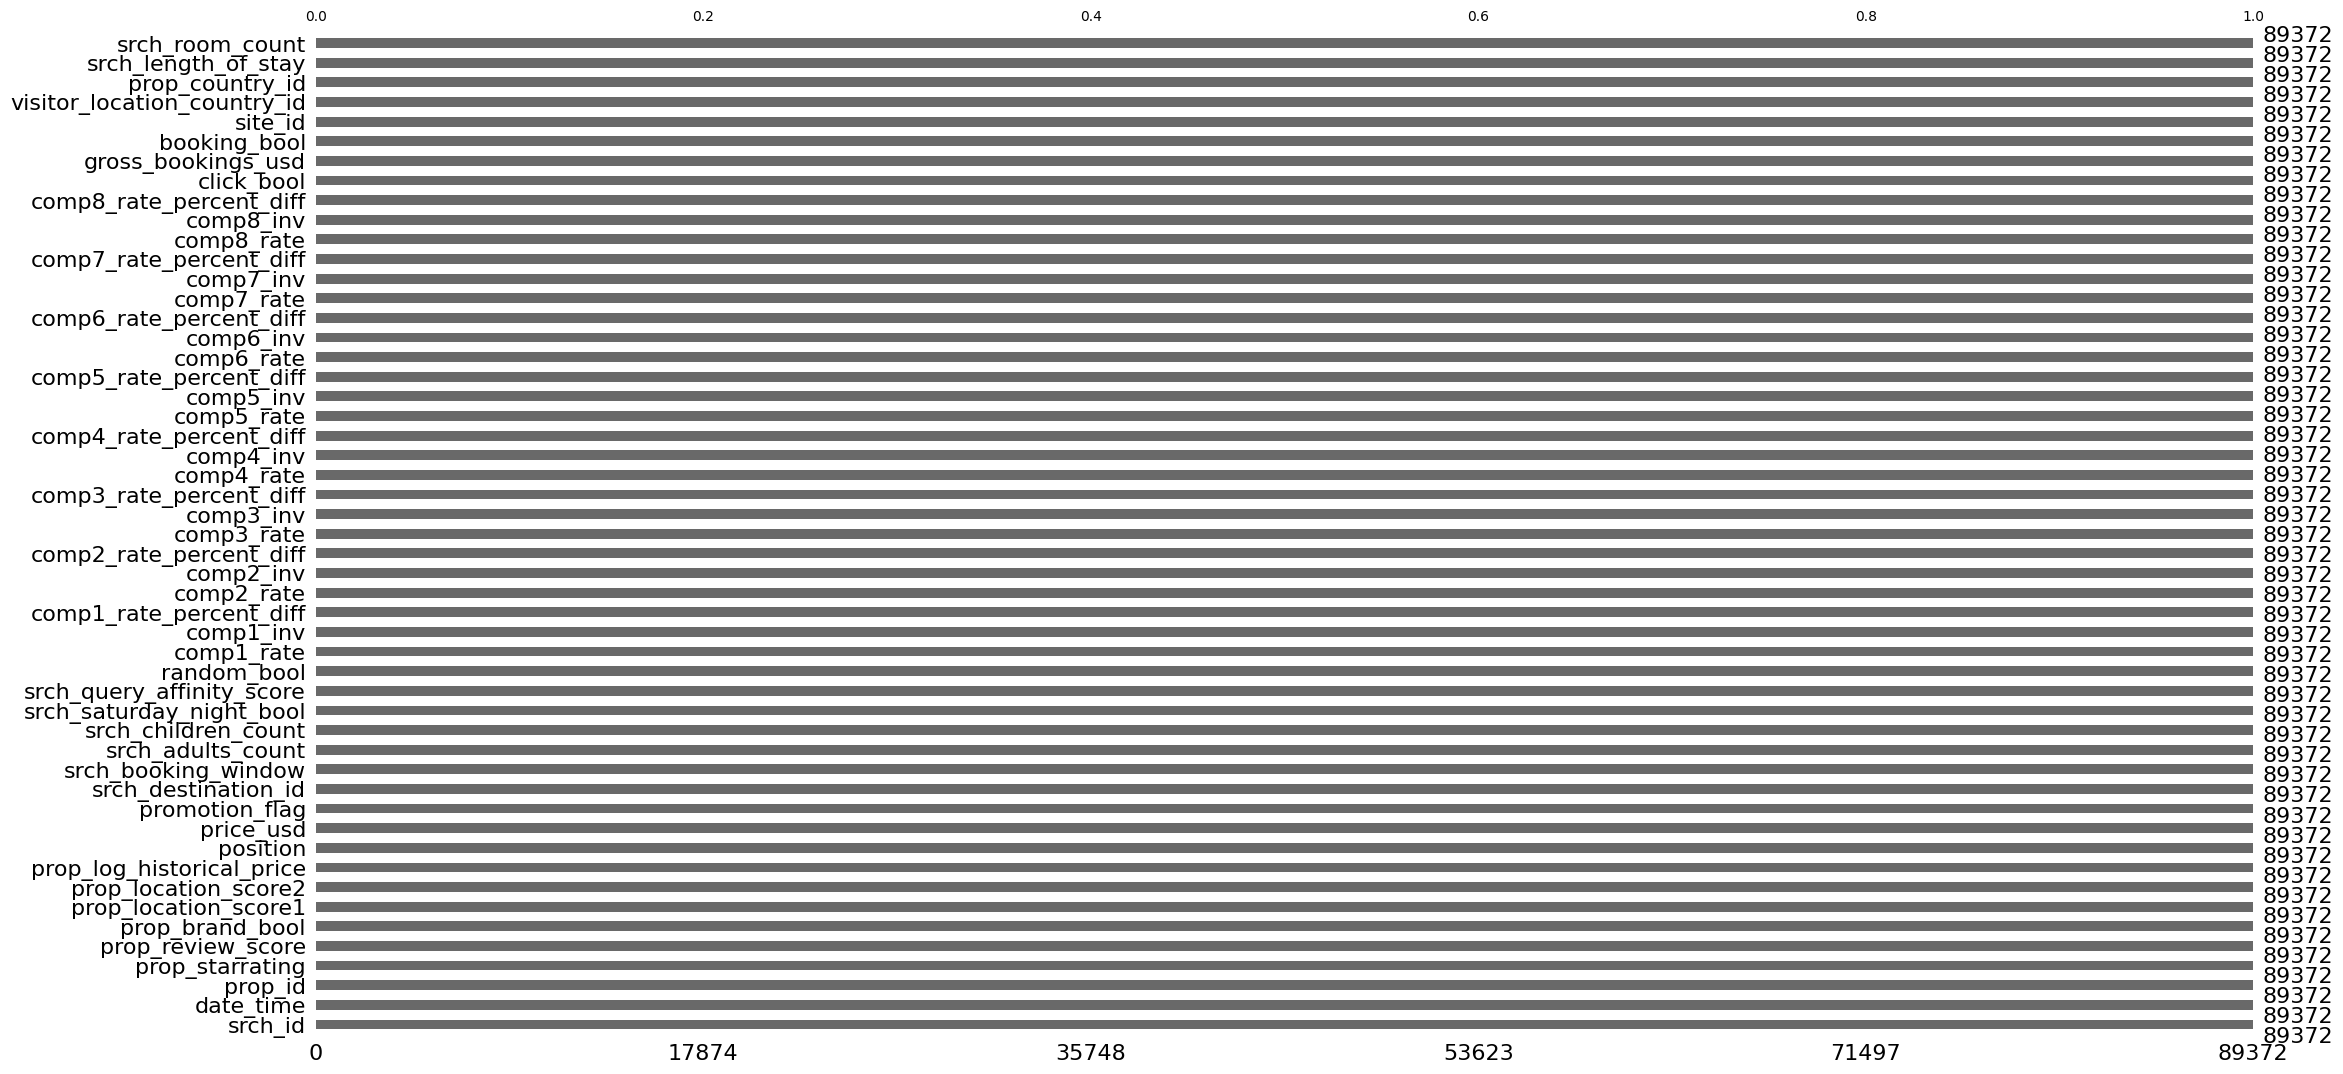

In [11]:
msno.bar(cleaner_samples)

In [12]:
from pandas_profiling import ProfileReport
# profile = ProfileReport(cleaner_samples, title="Report")
# profile

/var/folders/np/jw5x576n65142gwpqzsykd_80000gn/T/ipykernel_34005/3287548154.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Invs and rates are clean. But the percent rates are not, we have a lot of outliers. 

In order to get a better understanding of the distribution of our data, outlier detection would be a necessary step to evaluate the data. In our model we will treat outliers as missing values, this way we can have enough data to work with without the need to remove a lot of datapoints.

In [13]:
if mode == "train" and not engineer_mode:
    def plot_correlation(df):
        plt.figure(figsize = (24, 12))
        corr = df.corr()
        sns.heatmap(corr, annot = True, linewidths = 1)
        plt.show()
        return corr['booking_bool'].abs().sort_values(ascending = False)

    res = plot_correlation(cleaner_samples)
    res

WORKS KINDA:
    
    - prop_location_score1, prop_location_score2: CORRELATION - prop_score
    - gross_bookings_usd, srch_length_of_stay: CORRELATION - booking_stay

NOT WORKING:

    - prop_starrating, prop_review_score: LIGHT CORRELATION
    - prop_country_id, visitor_location_country_id: CORRELATION
    - visitor_hist_adr_usd, visitor_hist_starrating: BIG CORRELATION, DOESNT WORK
    - srch_room_count, srch_adults_count: CORRELATION, intuitively not really a predictor or booking_bool
    - srch_saturday_night_bool, srch_length_of_stay: INVERSE CORRELATION, searching doesnt predict booking per se

In [14]:
def create_df_new_features(df):
    # Prop scores
    df["prop_score"] = df["prop_location_score2"]+df["prop_location_score1"]
    df = df.drop(["prop_location_score2", "prop_location_score1"] , axis=1)

    # Convert to datetime data type
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['day_id'] = df['date_time'].dt.day # Extract day    
    df['season_id'] = df['date_time'].dt.quarter # Extract season
    df = df.drop("date_time", axis=1)

    # Merge the competitor data
#     rates = [c for c in df.columns if c.endswith("_rate")]
#     invs = [c for c in df.columns if c.endswith("_inv")]
#     diffs = [c for c in df.columns if c.endswith("_diff")]
    
#     df["all_rates"] = df[rates].sum(axis=1)
#     df["all_invs"] = df[invs].sum(axis=1)
#     df["all_diffs"] = df[diffs].sum(axis=1)
    
    comp_col = [col for col in df.columns if col.endswith('rate')]
    dat_comp = df[comp_col]
    dat_comp_cheap = dat_comp[(dat_comp<0)].dropna(axis = 0, how = 'all').index
    dat_comp_exp = dat_comp[(dat_comp>0)].dropna(axis = 0, how = 'all').index
    dat_comp_same = dat_comp[(dat_comp==0)].dropna(axis = 0, how = 'all').index
    
    dat_comp['comp_dat'] = 0
    dat_comp.loc[dat_comp_cheap,'comp_dat'] = 1
    dat_comp.loc[dat_comp_same,'comp_dat'] = 0
    dat_comp.loc[dat_comp_exp,'comp_dat'] = 1
    dat_comp.loc[dat_comp_cheap,'comp_dat'] = -1
    df['comp_rate'] = dat_comp['comp_dat']
    
    # Remove all the comp cols
    comps = [c for c in df.columns if "comp" in c]
    df = df.drop(comps, axis=1)

    return df


clean_training2 = create_df_new_features(cleaner_samples)
    

/var/folders/np/jw5x576n65142gwpqzsykd_80000gn/T/ipykernel_34005/2126023731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_comp['comp_dat'] = 0
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Distribution plotting

In [15]:
# Plot the counts
def plot_data(df, is_float):
    num_rows = len(df.columns) // 2 + len(df.columns) % 2

    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*3))

    for i, col in enumerate(df.columns):
        ax = axs.flatten()[i]
        if not is_float:
            sns.histplot(df[col], ax=ax)
        else:
            sns.scatterplot(x=df.index, y=df[col], ax=ax)
        ax.set_title(col)

    # Remove unused subplots
    if len(df.columns) % 2 != 0:
        fig.delaxes(axs.flatten()[-1])

    plt.tight_layout()
    plt.show()

In [16]:
if mode == "train" and not engineer_mode:
    float_cols = clean_training2.select_dtypes(include=["float64"])
    int_cols = clean_training2.select_dtypes(include=["int64"])

    plot_data(clean_training2[int_cols.columns], False)
    plot_data(clean_training2[float_cols.columns], True)

From our analysis we can see that price_usd and srch_length_of_stay have some outliers. 

## Down- and upsampling the training dataset
For some data points we need to downsample and for some we need to upsample the data. i.e. when we look at booking bool, that checks whether a hotel is booked, a lot of hotels have not been booked. This would introduce a big bias towards the non-booking side.

### Detecting outliers and treating them

In [17]:
def find_outliers_and_normalize(end_df):
    id_cols = [c for c in end_df if "id" in c]
    
    # Filter out non-numeric columns
    df_numeric = end_df

    for column in df_numeric.select_dtypes(include=['float64']):
        Q1 = df_numeric[column].quantile(0.25)
        Q3 = df_numeric[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define a mask for values outside the IQR
        mask = ((df_numeric[column] < (Q1 - 1.5 * IQR)) | (df_numeric[column] > (Q3 + 1.5 * IQR)))

        # Replace outliers with NaN
        df_numeric.loc[mask, column] = np.nan

    # Impute/Replace NaN values with means
    df_numeric.fillna(df_numeric.mean(), inplace=True)

    # Normalize all data
    scaler = MinMaxScaler()
    non_id_df = df_numeric.drop(id_cols, axis=1)
    df_scaled = pd.DataFrame(scaler.fit_transform(non_id_df), columns=non_id_df.columns)
    return pd.concat([df_scaled, end_df[id_cols]], axis=1)


if mode == "train":
    res = find_outliers_and_normalize(clean_training2)
else:
    res = find_outliers_and_normalize(clean_training2)

In [18]:
def pca(df):
    cols_to_scale = ['prop_starrating', 'prop_review_score', 'prop_location_score1', 
                     'prop_location_score2', 'srch_adults_count', 'srch_room_count',
                     'srch_length_of_stay', "price_usd"]

    df_to_pca, df_other = df[cols_to_scale], df.drop(cols_to_scale, axis=1)
    
    # Do PCA only on the cols_to_scale these are specified
    pca = PCA()
    dat = pca.fit_transform(df_to_pca)
    explained_variance = pca.explained_variance_ratio_
    var_dat = pd.DataFrame({'variance' : explained_variance})
    plt.bar(var_dat.index,var_dat['variance'])
    plt.show()

    pcas = var_dat.cumsum().sort_values("variance", ascending=False)

    cumulative_variance = var_dat.cumsum()
    print(cumulative_variance)

    # Find the number of components needed to capture 95% of the variance
    n_components = len(cumulative_variance[cumulative_variance <= 0.95].dropna())

    # Fit PCA again with the optimal number of components
    pca = PCA(n_components=n_components)
    dat = pca.fit_transform(df_to_pca)
    var_dat = pd.DataFrame({'variance' : explained_variance})
    var_dat.cumsum()

    pca_df = pd.concat([pd.DataFrame(dat), df_other], axis=1)
    return pca_df

In [19]:
# pcad_df = pca(res)
pcad_df = res

In [20]:
# Cleaned data
if mode == "train":
    pcad_df.to_csv("100k_train_data.csv")
else:
    pcad_df.sample(n=100000).to_csv("100k_test_data.csv")

# Get 10k of samples from the final df
small_sample = pcad_df.sample(n=10000, random_state=1)
small_sample.to_csv("10k_data.csv" if mode == "train" else "10k_test_data.csv")

In [31]:
pcad_df.head(30)

,prop_starrating,prop_review_score,prop_brand_bool,prop_log_historical_price,position,price_usd,promotion_flag,srch_booking_window,srch_adults_count,srch_children_count,...,srch_room_count,prop_score,day,season,srch_id,prop_id,srch_destination_id,site_id,visitor_location_country_id,prop_country_id
0,0.6,0.833333,1.0,0.558219,0.794872,0.305297,0.0,0.010460,0.125,0.000000,...,0.0,0.140545,0.800000,1.000000,32317,104003,2549,5,219,219
1,0.6,1.000000,0.0,0.595890,0.358974,0.427019,0.0,0.087866,0.375,0.000000,...,0.0,0.375727,0.900000,0.333333,328724,14819,6678,15,55,4
2,0.6,0.833333,0.0,0.863014,0.076923,0.880782,1.0,0.186192,0.125,0.000000,...,0.0,0.739252,0.833333,1.000000,185383,80475,4562,32,220,219
3,0.6,0.833333,1.0,0.633562,0.179487,0.277057,1.0,0.016736,0.125,0.000000,...,0.0,0.608341,0.633333,0.000000,95061,40380,12454,14,100,100
4,0.8,0.666667,1.0,0.688356,0.153846,0.591513,1.0,0.313808,0.125,0.000000,...,0.0,0.728072,0.633333,0.333333,105633,59354,28254,15,55,220
5,0.8,0.833333,1.0,0.787671,0.000000,0.406627,0.0,0.253138,0.125,0.111111,...,0.0,0.444466,0.900000,0.000000,201535,82404,26413,5,219,219
6,0.8,0.666667,0.0,0.202055,0.076923,0.437887,0.0,0.359833,0.250,0.111111,...,0.0,0.402060,0.200000,0.000000,324655,95396,18979,15,55,74
7,0.8,0.666667,0.0,0.489726,0.769231,0.195940,1.0,0.138075,0.000,0.111111,...,0.0,0.000192,0.533333,0.333333,330291,136855,18433,18,129,129
8,1.0,0.833333,1.0,0.767123,0.076923,0.624851,1.0,0.351464,0.125,0.000000,...,0.0,0.595027,0.166667,0.000000,72323,115048,6792,32,220,100
9,0.8,0.666667,1.0,0.650685,0.307692,0.547855,0.0,0.027197,0.000,0.000000,...,0.0,0.526301,0.366667,0.333333,290876,58744,6171,32,220,220
